In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
from matplotlib.patches import Patch
import geopandas as gpd # Make sure geopandas is imported
import pandas as pd
import numpy as np

In [4]:
df_joined_2024 = pd.read_csv(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\Food_Crisis_Cluster\result_GeoRF_30\correspondence_table_2024.csv')

In [3]:
df_joined_2023 = pd.read_csv(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\Food_Crisis_Cluster\result_GeoRF_29\correspondence_table_2023.csv')

In [5]:
df_joined_2022 = pd.read_csv(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\Food_Crisis_Cluster\result_GeoRF_28\correspondence_table_2022.csv')
df_joined_2021 = pd.read_csv(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\Food_Crisis_Cluster\result_GeoRF_27\correspondence_table_2021.csv')

In [14]:



# read shapefile
gdf = gpd.read_file(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\1.Source Data\Outcome\FEWSNET_IPC\FEWS NET Admin Boundaries\FEWS_Admin_LZ_v3.shp')
# keep only admin_code and geometry
gdf = gdf[['admin_code', 'geometry']]
# merge df_joined and gdf using pandas
#rename adm_code to admin_code in df_joined



In [11]:
# add column to indicate years
df_joined_2024['year'] = 2024
df_joined_2023['year'] = 2023
df_joined_2022['year'] = 2022
df_joined_2021['year'] = 2021

X_partition = pd.concat([df_joined_2024, df_joined_2023, df_joined_2022, df_joined_2021], ignore_index=True)

In [12]:
#rename FEWSNET_admin_code to admin_code in X_partition
X_partition.rename(columns={'FEWSNET_admin_code': 'admin_code'}, inplace=True)

In [15]:
#group by admin_code and year, find the max of fews_ipc_crisis_pred and fews_ipc_crisis_true
X_partition = X_partition.merge(gdf, on='admin_code', how='left')
# convert to geopandas dataframe
X_partition = gpd.GeoDataFrame(X_partition, geometry='geometry')
del gdf

Skipping year 2021: No partition data available (all partition_id values are missing)


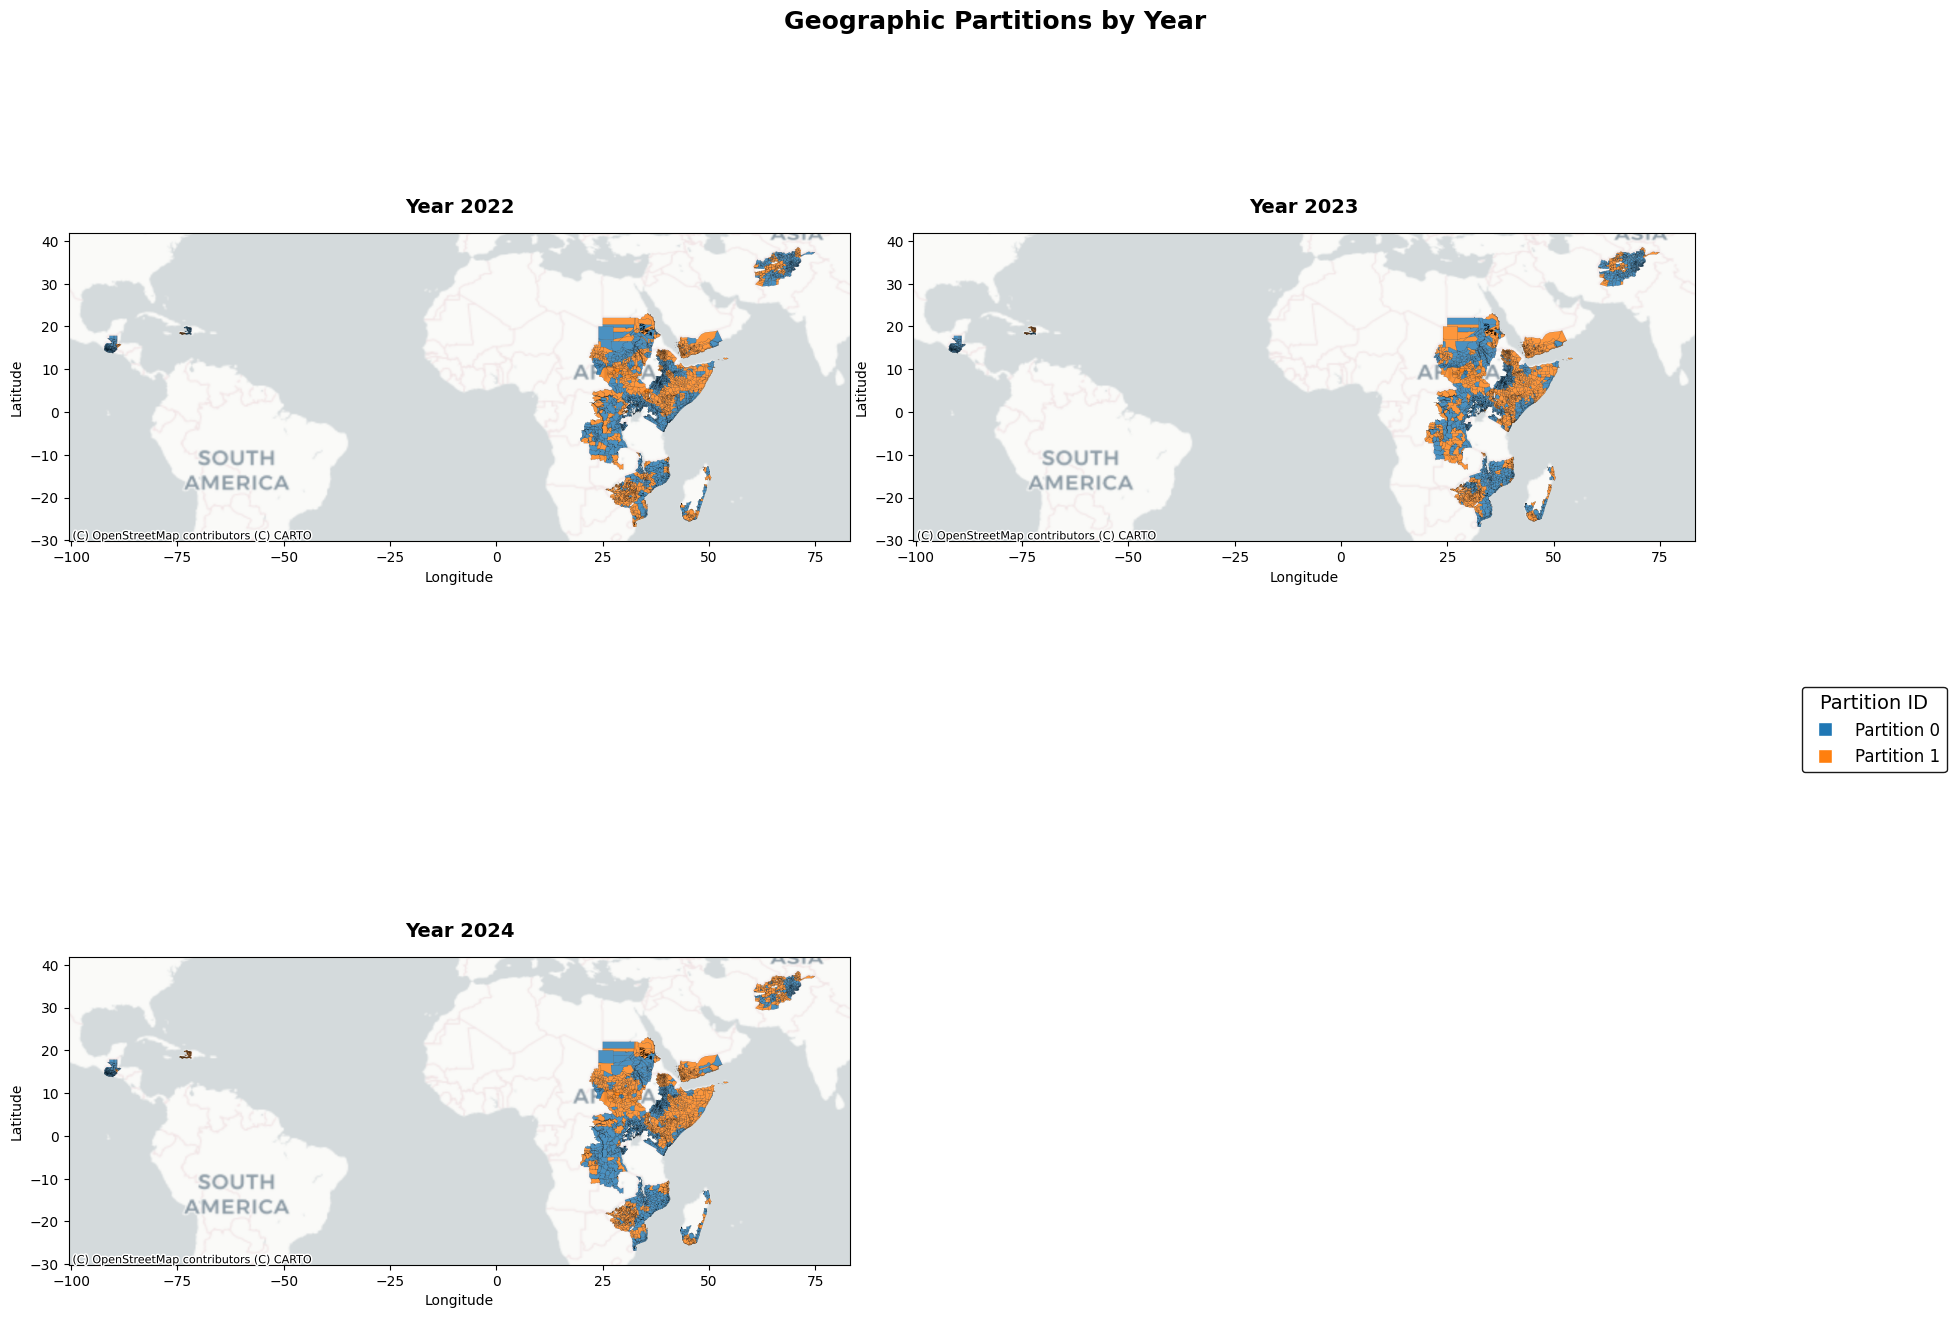

In [18]:
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors
import pandas as pd

# Get unique years and filter out years with all missing partition_id
all_years = sorted(X_partition['year'].unique())
valid_years = []

for year in all_years:
    year_data = X_partition[X_partition['year'] == year]
    # Check if all partition_id values are missing/null for this year
    if not year_data['partition_id'].isna().all():
        valid_years.append(year)
    else:
        print(f"Skipping year {year}: No partition data available (all partition_id values are missing)")

unique_years = valid_years

if len(unique_years) == 0:
    print("No valid years found with partition data. Exiting.")
    exit()

# Create figure with 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()  # Flatten for easier indexing

# Define custom colors for your partitions
partition_colors = {
    '0': '#1f77b4',  # Blue
    '1': '#ff7f0e',  # Orange
}

# Create a mapping from string IDs to numeric values for colormap
unique_partitions = sorted(partition_colors.keys())
partition_to_num = {pid: i for i, pid in enumerate(unique_partitions)}

# Create custom colormap
colors_list = [partition_colors[pid] for pid in unique_partitions]
cmap = mcolors.ListedColormap(colors_list)

# Plot each year in a separate subplot
for i, year in enumerate(unique_years):
    if i >= 4:  # Only handle up to 4 years for 2x2 layout
        break
        
    ax = axes[i]
    
    # Filter data for current year and remove rows with missing partition_id
    year_data = X_partition[X_partition['year'] == year].copy()
    year_data = year_data.dropna(subset=['partition_id'])
    
    # Skip if no valid data after removing missing partition_id
    if len(year_data) == 0:
        print(f"No valid partition data for year {year} after removing missing values")
        continue
    
    # Add a numeric column for plotting
    year_data['partition_numeric'] = year_data['partition_id'].map(partition_to_num)
    
    # Plot partitions with thin boundaries
    year_data.plot(
        ax=ax, 
        column='partition_id',
        cmap=cmap,
        legend=False,  # We'll add a single legend later
        alpha=0.8,
        edgecolor='black',  
        linewidth=0.1
    )
    
    # Add basemap with error handling
    try:
        ctx.add_basemap(
            ax, 
            crs=year_data.crs.to_string(), 
            source=ctx.providers.CartoDB.Positron,
            zoom='auto'
        )
    except Exception as e:
        print(f"Could not add basemap for year {year}: {e}")
    
    # Set title for each subplot
    ax.set_title(f'Year {year}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)

# Hide unused subplots if there are fewer than 4 years
for i in range(len(unique_years), 4):
    axes[i].set_visible(False)

# Add a single legend for all subplots
# Create a dummy plot for legend
legend_elements = []
for pid in unique_partitions:
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', 
                                    markerfacecolor=partition_colors[pid], 
                                    markersize=10, label=f'Partition {pid}'))

# Place legend outside the subplots
fig.legend(handles=legend_elements, 
          title='Partition ID', 
          loc='center right',
          bbox_to_anchor=(0.98, 0.5),
          fontsize=12,
          title_fontsize=14,
          frameon=True,
          facecolor='white',
          edgecolor='black',
          framealpha=0.9)

# Add overall title
fig.suptitle('Geographic Partitions by Year', fontsize=18, fontweight='bold', y=0.95)

# Adjust layout to make room for legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Save with high quality
plt.savefig('partition_map_yearly_gp.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [6]:
# rename fews_ipc_crisis_pred as alert_status, fews_ipc_crisis_true as actual_alert_status
df_joined.rename(columns={
    'fews_ipc_crisis_pred': 'alert_status',
    'fews_ipc_crisis_true': 'actual_alert_status'
}, inplace=True)

In [ ]:

# --- Configuration for the plot grid ---
years_to_plot = [2021, 2022, 2023, 2024] # years to plot
status_columns_info = {
    'actual_alert_status': 'Actual Alert Status',
    'alert_status': 'Predicted Alert Status'
}
plot_columns_keys = list(status_columns_info.keys())

# --- Nature-like Style Adjustments ---
plt.rcParams.update({
    'font.family': 'sans-serif', # Use a sans-serif font
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans', 'Bitstream Vera Sans'], # Preferred sans-serif fonts
    'axes.titlesize': 9,       # Smaller default axes title size
    'axes.labelsize': 8,       # Smaller default label size (though not used here)
    'xtick.labelsize': 8,      # Smaller tick label size (though not used here)
    'ytick.labelsize': 8,      # Smaller tick label size (though not used here)
    'legend.fontsize': 6,      # Smaller default legend font size
    'figure.titlesize': 12     # Smaller default figure title size
})

# Create the figure and axes grid
fig, axes = plt.subplots(nrows=len(years_to_plot),
                         ncols=len(plot_columns_keys),
                         figsize=(10, 15)) # Adjusted figsize slightly for potentially better aspect

# Flatten axes array for easier single-plot handling if necessary
# This simplifies access compared to multiple conditional checks inside the loop
if len(years_to_plot) == 1 and len(plot_columns_keys) == 1:
    axes_flat = [axes]
elif len(years_to_plot) == 1:
     axes_flat = axes # axes is already 1D array
elif len(plot_columns_keys) == 1:
     axes_flat = axes # axes is already 1D array
else: # 2D array
    axes_flat = axes.flatten()


plot_counter = 0 # To iterate through axes_flat
gdf_main = df_joined.copy() # Use the main GeoDataFrame for plotting
for row_idx, year in enumerate(years_to_plot):
    gdf_month_base = gdf_main[gdf_main['year'] == year].copy()

    if gdf_month_base.empty:
        print(f"No data for year {year}. Skipping plots for this year.")
        # Still need to handle turning off axes for the empty slots in the grid
        for col_idx in range(len(plot_columns_keys)):
            if plot_counter < len(axes_flat):
                 ax = axes_flat[plot_counter]
                 ax.set_axis_off()
                 ax.set_title(f"{status_columns_info.get(plot_columns_keys[col_idx],'Unknown Status')}\nYear: {year} - No Data", fontsize=8) # Adjusted title size
            plot_counter += 1
        continue # Skip to the next year

    for col_idx, status_col_name in enumerate(plot_columns_keys):
        if plot_counter >= len(axes_flat):
             print("Warning: More data combinations than axes available.")
             break # Avoid index error

        ax = axes_flat[plot_counter] # Get the current axis
        gdf = gdf_month_base.copy()

        # --- CRS Handling ---
        original_crs = gdf.crs
        target_crs = "EPSG:3857" # Web Mercator for contextily

        if original_crs is None:
            print(f"Warning: CRS not found for year {year}, {status_col_name}. Assuming EPSG:4326.")
            gdf.crs = "EPSG:4326" # Assume WGS84
            original_crs = gdf.crs # Update for potential reprojection check
        
        # Reproject if necessary
        if original_crs != target_crs:
             try:
                 gdf = gdf.to_crs(crs=target_crs)
             except Exception as e:
                 print(f"Error reprojecting GDF for year {year}, {status_col_name} from {original_crs} to {target_crs}: {e}")
                 ax.set_title(f"Error in {status_columns_info[status_col_name]}\nYear: {year}\nCRS Reprojection Failed", fontsize=7) # Smaller error font
                 ax.set_axis_off()
                 plot_counter += 1
                 continue # Skip to next plot

        # --- Plotting ---
        # Plot base outlines first
        gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.2) # Slightly thicker outline for visibility on basemap

        if status_col_name not in gdf.columns:
            print(f"Warning: Column '{status_col_name}' not found in data for year {year}.")
            ax.set_title(f"{status_columns_info.get(status_col_name, status_col_name)}\nYear: {year}\nData Column Missing", fontsize=7) # Smaller error font
            ax.set_axis_off()
            plot_counter += 1
            continue # Skip to next plot

        unique_statuses_in_plot = gdf[status_col_name].dropna().unique() # Add dropna()

        # Define colors
        colors_labels_dict = {0: ('#1a9641', 'No Crisis'), 1: ('#d7191c', 'Crisis')} # Nature-style green/red hex codes

        # Plot based on status
        plotted_something = False
        if 0 in unique_statuses_in_plot:
            try:
                gdf[gdf[status_col_name] == 0].plot(ax=ax, color=colors_labels_dict[0][0], aspect='equal')
                plotted_something = True
            except Exception as e:
                 print(f"Error plotting status 0 for {year}, {status_col_name}: {e}")
        if 1 in unique_statuses_in_plot:
            try:
                 gdf[gdf[status_col_name] == 1].plot(ax=ax, color=colors_labels_dict[1][0], aspect='equal')
                 plotted_something = True
            except Exception as e:
                 print(f"Error plotting status 1 for {year}, {status_col_name}: {e}")

        if not plotted_something and not gdf.empty :
            # If no specific status data but geometry exists, maybe show the outline?
             gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.2, aspect='equal')


        # --- Basemap ---
        try:
            # Use a simple, light basemap provider
            ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels, zoom='auto', attribution_size=5)
        except Exception as e:
            print(f"Could not add basemap for year {year}, {status_col_name}: {e}. Continuing without basemap.")

        # --- Axis Off ---
        ax.set_axis_off()

        # --- Legend ---
        legend_handles = []
        # Create handles only for statuses actually present *and plotted*
        # Check unique statuses again AFTER potential plotting errors / empty filters
        actual_plotted_statuses = gdf[status_col_name].dropna().unique()
        if 0 in actual_plotted_statuses:
            legend_handles.append(Patch(color=colors_labels_dict[0][0], label=colors_labels_dict[0][1]))
        if 1 in actual_plotted_statuses:
            legend_handles.append(Patch(color=colors_labels_dict[1][0], label=colors_labels_dict[1][1]))

        if legend_handles:
            ax.legend(handles=legend_handles,
                      title="Alert Status", # Simplified title
                      loc='upper left',
                      fontsize=6, # Smaller legend text font size (points)
                      title_fontsize=7, # Smaller legend title font size (points)
                      frameon=False, # Remove legend frame for cleaner look
                      labelspacing=0.2, # Reduce spacing between legend items
                      handletextpad=0.5) # Reduce padding between handle and text


        # --- Subplot Title ---
        ax.set_title(f'{status_columns_info[status_col_name]}\nYear: {year}', fontsize=9, pad=2) # Reduced padding below title

        plot_counter += 1 # Increment the counter for the flattened axes

# --- Overall Figure Title ---
fig.suptitle('Actual vs. Predicted Alert Status', fontsize=12, y=0.99, weight='bold') # Slightly smaller, bold

# --- Adjust layout ---
# Use subplots_adjust for finer control over spacing, making subplots relatively larger
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.93, wspace=0.1, hspace=0.2) # Reduced wspace and hspace

# --- Save and Show ---
output_filename = "global_alert_status_grid_nature_style_polygon_forecasting.png"
try:
    plt.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white') # Ensure white background
    print(f"Plot successfully saved as {output_filename}")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()